In [1]:
# from google.colab import drive
# import sys
# drive.mount('/content/drive',force_remount=True)
# sys.path.insert(0,'/content/drive/MyDrive/EPF notebooks/deep_learning_project')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

from package import batch_gd, report,train_dataset, test_dataset, \
    transforms, train_loader, test_loader, EarlyStopping

# **Early stopping**

We saw in the precedent notebook that our EfficientNet model is subject to overfitting, likely because of the size of the model compared to the difficulty of the task.

Here, we will implement early_stopping to interrupt training before the model starts to overfit.

In [3]:
def build_model(pretrained=True, fine_tune=True, num_classes=43):
  """
  pretrained: boolean value indicating whether we want to load the ImageNet weights or not
  fine_tune: boolean value. When it is True, all the intermediate layers will also be trained
  """
  if pretrained:
      print('Loading pre-trained weights')
      model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
  else:
      print('Not loading pre-trained weights')
      model = models.efficientnet_v2_s()
  if fine_tune:
      print('Fine-tuning all layers')
      for params in model.parameters():
          params.requires_grad = True
  elif not fine_tune:
      print('Freezing hidden layers')
      for params in model.parameters():
          params.requires_grad = False
  # Change the final classification head
  model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
  return model

In [4]:
model = build_model(pretrained=True, fine_tune=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Loading pre-trained weights
Fine-tuning all layers


In [10]:
#model # uncomment to see the full architecture

We are only interested in the last layer (the classifier). Indeed we'll replace it with a new layer to act as a new classifier. Here 1280 input features will be needed.

```Python 
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

In [11]:
early_stopping = EarlyStopping(patience=1, min_delta=0)

In [12]:
train_losses, test_losses = batch_gd(model=model,
                                    criterion=criterion,
                                    optimizer=optimizer,
                                    train_loader=train_loader,
                                    test_loader=test_loader,
                                    early_stopping=True,
                                    early_stopper=early_stopping,
                                    epochs=10)

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 1 / 10: Train Loss : 0.2467, Test Loss : 0.1257, duration: 0:02:22.460980


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 2 / 10: Train Loss : 0.0339, Test Loss : 0.1097, duration: 0:02:16.119604


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 3 / 10: Train Loss : 0.0129, Test Loss : 0.0772, duration: 0:02:15.753563


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Stopped at epoch: 4 with Train Loss : 0.0208, Test Loss : 0.1181


In [5]:
WEIGHTS_PATH = '/content/drive/MyDrive/EPF notebooks/deep_learning_project/efficient_net_early_stopping'
# torch.save(model.state_dict(), WEIGHTS_PATH)

In [6]:
model.load_state_dict(torch.load(WEIGHTS_PATH))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [7]:
# reduce the batch size and empty the cach to avoid memory issues
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)
torch.cuda.empty_cache()

  0%|          | 0/198 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        60
         1.0       1.00      0.98      0.99       720
         2.0       0.99      1.00      0.99       750
         3.0       0.98      0.96      0.97       450
         4.0       1.00      0.99      1.00       660
         5.0       0.94      0.99      0.97       630
         6.0       1.00      0.87      0.93       150
         7.0       1.00      1.00      1.00       450
         8.0       1.00      0.94      0.97       450
         9.0       1.00      0.99      0.99       480
        10.0       1.00      1.00      1.00       660
        11.0       0.95      1.00      0.97       420
        12.0       1.00      0.99      0.99       690
        13.0       0.99      1.00      0.99       720
        14.0       1.00      1.00      1.00       270
        15.0       1.00      0.85      0.92       210
        16.0       0.97      1.00      0.98       150
        17.0       1.00    

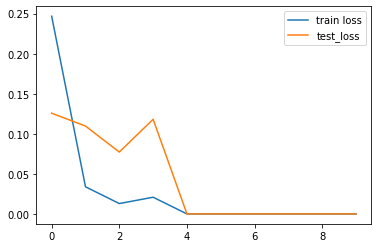

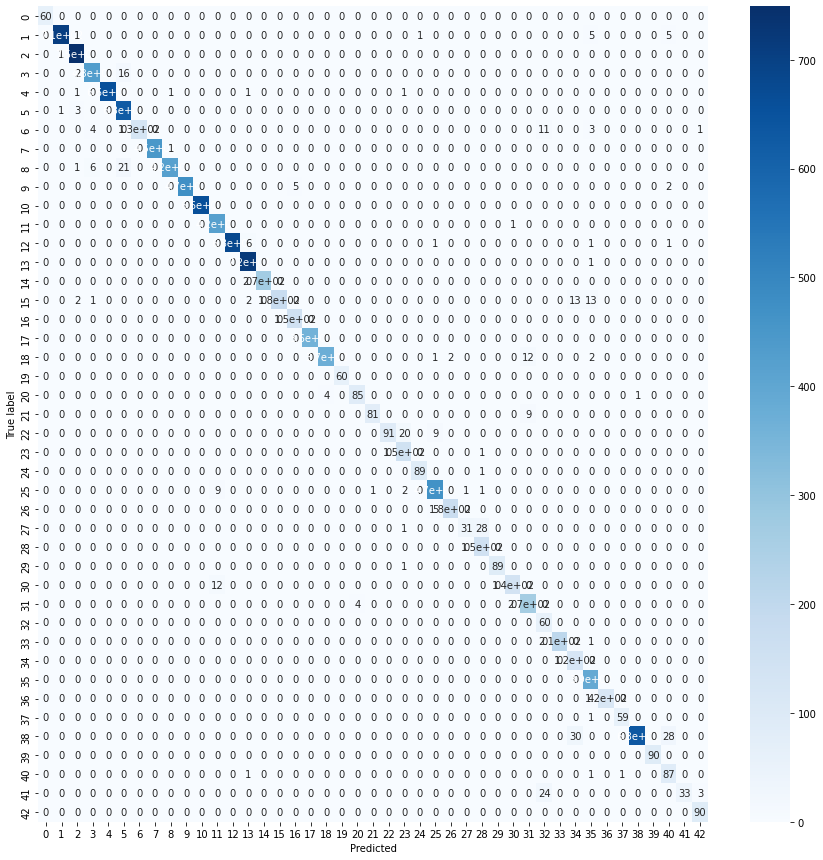

In [9]:
train_losses = np.array([0.24674824, 0.0338611 , 0.0129292 , 0.02083501, 0.,0., 0., 0., 0., 0.])
test_losses = np.array([0.12570556, 0.1096828 , 0.07721394, 0.11810752, 0.,0., 0., 0., 0., 0.])

X_test, p_test, y_test = report(model,test_loader, train_losses, test_losses)

# **Conclusion**

The pretrained EfficientNet V2 (small version) outperformed our previous CNN after training for only 4 epochs instead of 10.

The early stopping allowed to stop the training before the model started overfitting, which happened quite quickly in the last notebook. This is probably due to the fact that using such a big model is 'overkill' for the task we perform. Both our previous CNNs were quite small and already achieved high performances with little training.

Transfer learning is definitely a useful tool to use and allows to gain time by skipping the architecture design phase. Pretrained models are also a lot faster to train than regular models from the same size as the weights are already closer to the desired values.  